# Step 1

Dossier images existe : True
Fichier labels existe : True

--- Chargement des données ---
✅ Chargement réussi ! Total images valides : 90000
     filename  target  gender
0  000000.jpg      -1      -1
1  000001.jpg       1      -1
2  000002.jpg      -1      -1
3  000003.jpg      -1       1
4  000004.jpg       1       1

--- Distribution Croisée (Genre x Target) ---


,Target -1,Target 1
Femmes (-1),40005,13033
Hommes (1),32516,4446


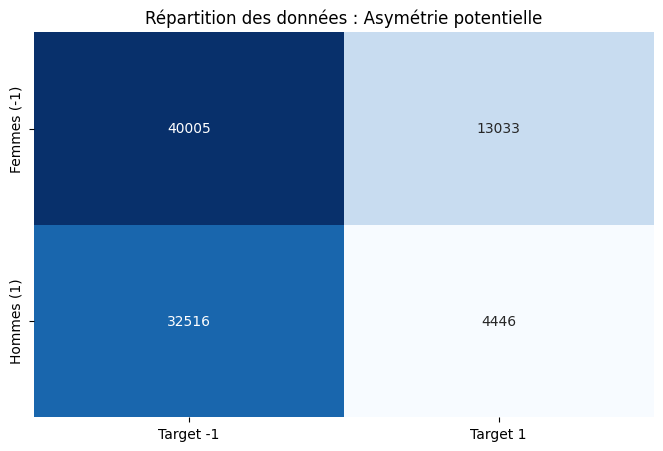


--- Visualisation des échantillons ---


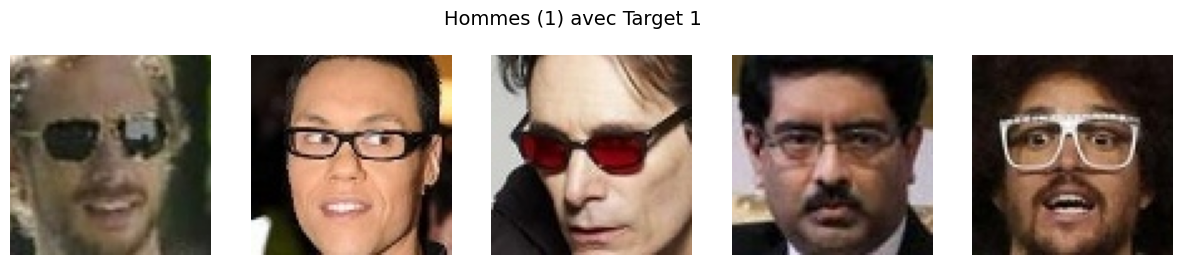

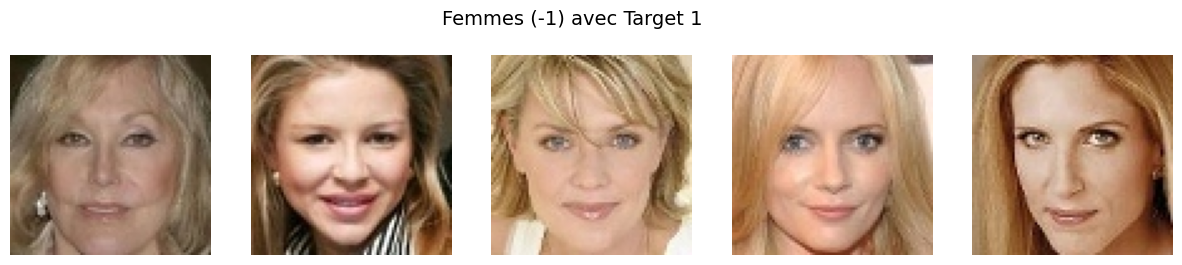


--- Split Terminé ---
Train Set : 72000 images
Val Set   : 18000 images


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

# ==========================================
# 1. CONFIGURATION DES CHEMINS
# ==========================================
# Adaptez ces chemins selon votre dossier (ex: sur Colab: '/content/drive/...')
TRAIN_DIR = './train'        # Dossier contenant les 90 000 images
LABELS_PATH = './train.txt'  # Fichier texte des labels

print(f"Dossier images existe : {os.path.exists(TRAIN_DIR)}")
print(f"Fichier labels existe : {os.path.exists(LABELS_PATH)}")

# ==========================================
# 2. CHARGEMENT ET NETTOYAGE DES LABELS
# ==========================================
print("\n--- Chargement des données ---")
try:
    # Utilisation de regex separator (r"\s+") pour gérer les espaces multiples
    # engine='python' est plus stable pour ce type de fichier
    df = pd.read_csv(LABELS_PATH, sep=r"\s+", names=['filename', 'target', 'gender'], engine='python')

    # Détection et suppression des lignes malformées (NaN)
    nan_count = df.isna().sum().sum()
    if nan_count > 0:
        print(f"⚠️ Attention : {nan_count} valeurs manquantes supprimées.")
        df = df.dropna()

    # Conversion explicite en entiers
    df['target'] = df['target'].astype(int)
    df['gender'] = df['gender'].astype(int)

    print(f"✅ Chargement réussi ! Total images valides : {len(df)}")
    print(df.head())

except Exception as e:
    print(f"❌ Erreur critique : {e}")
    raise

# ==========================================
# 3. ANALYSE DE L'ASYMÉTRIE (Déséquilibre)
# ==========================================
# Cette étape répond à la question : "Est-ce que l'asymétrie est un problème ?" [cite: 28]

# Table de contingence : Combien d'Hommes/Femmes pour chaque Target ?
cross_tab = pd.crosstab(df['gender'], df['target'])
cross_tab.index = ['Femmes (-1)', 'Hommes (1)']
cross_tab.columns = ['Target -1', 'Target 1']

print("\n--- Distribution Croisée (Genre x Target) ---")
display(cross_tab)

# Visualisation
plt.figure(figsize=(8, 5))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Répartition des données : Asymétrie potentielle")
plt.show()

# ==========================================
# 4. VISUALISATION DES IMAGES "SOFTBIO"
# ==========================================
# Pour comprendre ce que le modèle doit chercher (chapeau, lunettes, etc.)

def show_examples(df, folder, target, gender, title, n=5):
    subset = df[(df['target'] == target) & (df['gender'] == gender)]
    if len(subset) == 0: return

    samples = subset.sample(min(n, len(subset)))

    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=14)
    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(folder, row['filename'])
        try:
            img = Image.open(img_path)
            plt.subplot(1, n, i+1)
            plt.imshow(img)
            plt.axis('off')
        except:
            pass
    plt.show()

print("\n--- Visualisation des échantillons ---")
show_examples(df, TRAIN_DIR, target=1, gender=1, title="Hommes (1) avec Target 1")
show_examples(df, TRAIN_DIR, target=1, gender=-1, title="Femmes (-1) avec Target 1")
# Astuce : Regardez les points communs (ex: sourires, lunettes, frange ?)

# ==========================================
# 5. SPLIT TRAIN / VALIDATION (Stratifié)
# ==========================================
# On crée un jeu de validation qui a EXACTEMENT la même proportion
# de femmes/hommes/targets que le jeu d'entrainement.

# Création d'une colonne temporaire combinant les deux labels pour stratifier
df['stratify_col'] = df['target'].astype(str) + "_" + df['gender'].astype(str)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,       # 20% pour valider (18 000 images)
    random_state=42,     # Reproductibilité
    stratify=df['stratify_col'] # Stratification double
)

# Nettoyage
train_df = train_df.drop(columns=['stratify_col'])
val_df = val_df.drop(columns=['stratify_col'])

print("\n--- Split Terminé ---")
print(f"Train Set : {len(train_df)} images")
print(f"Val Set   : {len(val_df)} images")

# Step 2

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import optuna
import os
from PIL import Image
import numpy as np

# Configuration Matérielle
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Optimisation sur : {DEVICE}")

# ==========================================
# 1. DÉFINITION DU DATASET
# ==========================================
class FaceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]['filename'])

        try:
            image = Image.open(img_name).convert('RGB')
        except:
            image = Image.new('RGB', (80, 80))

        target_val = 1.0 if self.dataframe.iloc[idx]['target'] == 1 else 0.0
        gender_val = 1.0 if self.dataframe.iloc[idx]['gender'] == 1 else 0.0

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(target_val, dtype=torch.float32), torch.tensor(gender_val, dtype=torch.float32)

train_transforms = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Instanciation
train_ds = FaceDataset(train_df, TRAIN_DIR, transform=train_transforms)
val_ds = FaceDataset(val_df, TRAIN_DIR, transform=val_transforms)

# ==========================================
# 2. ARCHITECTURE
# ==========================================
class DynamicCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(DynamicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(256 * 5 * 5, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

# ==========================================
# 3. RANDOM SEARCH OPTIMISÉ
# ==========================================

def calculate_esiea_metric(preds, targets, genders):
    preds_bin = (torch.sigmoid(preds) > 0.5).float()
    mask_m = (genders == 1)
    mask_f = (genders == 0)
    acc_m = (preds_bin[mask_m] == targets[mask_m]).float().mean().item() if mask_m.sum() > 0 else 0
    acc_f = (preds_bin[mask_f] == targets[mask_f]).float().mean().item() if mask_f.sum() > 0 else 0
    return ((acc_m + acc_f) / 2) - (2 * abs(acc_m - acc_f))

def objective(trial):
    # A. Hyperparamètres
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.2, 0.6)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    smoothing = trial.suggest_float("label_smoothing", 0.0, 0.15)

    # B. Subsampling pour aller vite (10% des données seulement pour la recherche)
    # C'est crucial car vous êtes sur CPU
    indices = np.random.choice(len(train_ds), size=int(len(train_ds)*0.3), replace=False)
    train_subset = Subset(train_ds, indices)

    # Ici aussi on réduit le val set pour la recherche
    val_indices = np.random.choice(len(val_ds), size=int(len(val_ds)*0.4), replace=False)
    val_subset = Subset(val_ds, val_indices)

    # C. Dataloaders avec num_workers=0 (FIX DU BUG)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)

    model = DynamicCNN(dropout_rate=dropout).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # D. Boucle rapide (2 époques suffisent avec le subset)
    for epoch in range(2):
        model.train()
        for images, targets, _ in train_loader:
            # Lissage manuel
            targets_smoothed = targets * (1 - smoothing) + 0.5 * smoothing
            images, targets_smoothed = images.to(DEVICE), targets_smoothed.to(DEVICE).unsqueeze(1)

            optimizer.zero_grad()
            loss = criterion(model(images), targets_smoothed)
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        all_preds, all_targs, all_gends = [], [], []
        with torch.no_grad():
            for imgs, targs, gends in val_loader:
                imgs = imgs.to(DEVICE)
                outputs = model(imgs)
                all_preds.append(outputs.cpu())
                all_targs.append(targs)
                all_gends.append(gends)

        score = calculate_esiea_metric(
            torch.cat(all_preds),
            torch.cat(all_targs).unsqueeze(1),
            torch.cat(all_gends).unsqueeze(1)
        )

        trial.report(score, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return score

print("Démarrage du Random Search (Version CPU Safe & Rapide)...")
study = optuna.create_study(direction="maximize")
# On limite à 5 essais pour que ça ne prenne pas toute la journée sur CPU
study.optimize(objective, n_trials=10)

print("-" * 40)
print(f"Meilleur Score ESIEA : {study.best_value:.4f}")
print("Meilleurs Paramètres : ", study.best_params)

[I 2025-11-20 14:43:39,058] A new study created in memory with name: no-name-5984ac79-7e40-4efb-bbc7-2e11bf431eab


Optimisation sur : cpu
Démarrage du Random Search (Version CPU Safe & Rapide)...


[I 2025-11-20 14:49:20,885] Trial 0 finished with value: 0.8233712017536163 and parameters: {'lr': 0.0010678322203634789, 'dropout': 0.4513587917827853, 'batch_size': 64, 'label_smoothing': 0.09987481961413386}. Best is trial 0 with value: 0.8233712017536163.
[I 2025-11-20 14:54:01,669] Trial 1 finished with value: 0.8218580186367035 and parameters: {'lr': 0.00015205986933252458, 'dropout': 0.42233098285144016, 'batch_size': 64, 'label_smoothing': 0.025029138625318158}. Best is trial 0 with value: 0.8233712017536163.
[I 2025-11-20 14:58:54,310] Trial 2 finished with value: 0.8303735554218292 and parameters: {'lr': 0.0005241597320995532, 'dropout': 0.37887530194203073, 'batch_size': 64, 'label_smoothing': 0.08241461019892267}. Best is trial 2 with value: 0.8303735554218292.
[I 2025-11-20 15:03:33,493] Trial 3 finished with value: 0.8402578234672546 and parameters: {'lr': 0.0001843693916067429, 'dropout': 0.5882940007335425, 'batch_size': 64, 'label_smoothing': 0.046287086000741856}. Bes

----------------------------------------
Meilleur Score ESIEA : 0.8648
Meilleurs Paramètres :  {'lr': 0.0008043319031691085, 'dropout': 0.3510417764943409, 'batch_size': 32, 'label_smoothing': 0.10753515327334742}


# Step 3

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import numpy as np
from tqdm import tqdm  # Pour la barre de progression

# ==========================================
# 1. CONFIGURATION (A REMPLIR AVEC VOS RESULTATS STEP 2)
# ==========================================
# Exemple de valeurs (remplacez par celles d'Optuna)
BEST_PARAMS = {
    "lr": 0.0008043319031691085,
    "dropout": 0.3510417764943409,
    "label_smoothing": 0.10753515327334742,
    "batch_size": 32
}

EPOCHS = 10  # Nombre d'époques pour l'entraînement final
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NOM_FICHIER_RENDU = "predictions_Binome1_Binome2.txt" #

print(f"Entraînement final sur {DEVICE} avec params : {BEST_PARAMS}")

# ==========================================
# 2. RAPPEL ARCHITECTURE & DATASET
# ==========================================
# On redéfinit pour être sûr que tout est autonome
class FaceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self): return len(self.dataframe)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]['filename'])
        try: image = Image.open(img_name).convert('RGB')
        except: image = Image.new('RGB', (80, 80))
        target = 1.0 if self.dataframe.iloc[idx]['target'] == 1 else 0.0
        gender = 1.0 if self.dataframe.iloc[idx]['gender'] == 1 else 0.0
        if self.transform: image = self.transform(image)
        return image, torch.tensor(target).float(), torch.tensor(gender).float()

class DynamicCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(DynamicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(256 * 5 * 5, 512), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(512, 1)
        )
    def forward(self, x): return self.classifier(self.flatten(self.features(x)))

# Préparation des données complètes
train_loader = DataLoader(train_ds, batch_size=BEST_PARAMS['batch_size'], shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BEST_PARAMS['batch_size'], shuffle=False, num_workers=0)

# ==========================================
# 3. BOUCLE D'ENTRAÎNEMENT "FAIRNESS-AWARE"
# ==========================================
def calculate_esiea_metric(preds, targets, genders):
    preds_bin = (torch.sigmoid(preds) > 0.5).float()
    mask_m, mask_f = (genders == 1), (genders == 0)
    acc_m = (preds_bin[mask_m] == targets[mask_m]).float().mean().item() if mask_m.sum() > 0 else 0
    acc_f = (preds_bin[mask_f] == targets[mask_f]).float().mean().item() if mask_f.sum() > 0 else 0
    # Métrique : Moyenne - 2 * |Différence|
    return ((acc_m + acc_f) / 2) - (2 * abs(acc_m - acc_f)), acc_m, acc_f

model = DynamicCNN(dropout_rate=BEST_PARAMS['dropout']).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=BEST_PARAMS['lr'])
criterion = nn.BCEWithLogitsLoss()

best_score = -float('inf')
print("\nDébut de l'entraînement final...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    # Barre de progression pour suivre l'époque
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, targets, _ in pbar:
        # Lissage manuel des labels (Robustesse au bruit)
        smooth = BEST_PARAMS['label_smoothing']
        targets_smooth = targets * (1 - smooth) + 0.5 * smooth

        images, targets_smooth = images.to(DEVICE), targets_smooth.to(DEVICE).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets_smooth)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})

    # Validation & Sauvegarde du meilleur modèle selon métrique ESIEA
    model.eval()
    all_preds, all_targs, all_gends = [], [], []
    with torch.no_grad():
        for imgs, targs, gends in val_loader:
            imgs = imgs.to(DEVICE)
            all_preds.append(model(imgs).cpu())
            all_targs.append(targs)
            all_gends.append(gends)

    score, acc_h, acc_f = calculate_esiea_metric(
        torch.cat(all_preds), torch.cat(all_targs).unsqueeze(1), torch.cat(all_gends).unsqueeze(1)
    )

    print(f"Epoch {epoch+1} | ESIEA Score: {score:.4f} (Hommes: {acc_h:.2%}, Femmes: {acc_f:.2%})")

    # Sauvegarde si on bat le record
    if score > best_score:
        best_score = score
        torch.save(model.state_dict(), "models/best_model_esiea - v1.pth")
        print(">>> Nouveau meilleur modèle sauvegardé !")

# ==========================================
# 4. GÉNÉRATION DES PRÉDICTIONS (TEST)
# ==========================================
print("\n--- Génération du fichier de rendu ---")

# Chargement du meilleur modèle
model.load_state_dict(torch.load("models/best_model_esiea - v1.pth", map_location=DEVICE))
model.eval()

# Gestion de la liste des fichiers de test
TEST_DIR = './test'
test_files = []

# On essaie de lire test.txt si fourni, sinon on liste le dossier
if os.path.exists('test.txt'):
    with open('test.txt', 'r') as f:
        # On suppose que le fichier contient juste les noms d'images
        test_files = [line.strip().split()[0] for line in f.readlines() if line.strip()]
else:
    # Fallback : on liste le dossier et on trie
    print("⚠️ Fichier 'test.txt' non trouvé. Utilisation de os.listdir trié.")
    test_files = sorted([f for f in os.listdir(TEST_DIR) if f.endswith('.jpg')])

# Prédictions
predictions = []
print(f"Traitement de {len(test_files)} images de test...")

with torch.no_grad():
    for img_name in tqdm(test_files):
        path = os.path.join(TEST_DIR, img_name)
        try:
            img = Image.open(path).convert('RGB')
            # Même transfo que validation
            img_tensor = val_transforms(img).unsqueeze(0).to(DEVICE)

            output = model(img_tensor)
            prob = torch.sigmoid(output).item()

            # Conversion en label original (-1 ou 1)
            pred_label = 1 if prob > 0.5 else -1
            predictions.append(f"{img_name} {pred_label}")

        except Exception as e:
            print(f"Erreur sur {img_name}: {e}")
            predictions.append(f"{img_name} -1") # Valeur par défaut

# Écriture du fichier final
with open(NOM_FICHIER_RENDU, 'w') as f:
    for line in predictions:
        f.write(line + "\n")

print("-" * 30)
print(f"✅ Fichier généré : {NOM_FICHIER_RENDU}")
print(f"Ce fichier contient {len(predictions)} lignes.")
print("Vous pouvez maintenant rédiger votre rapport !")

Entraînement final sur cpu avec params : {'lr': 0.0008043319031691085, 'dropout': 0.3510417764943409, 'label_smoothing': 0.10753515327334742, 'batch_size': 32}

Début de l'entraînement final...


Epoch 1/10: 100%|██████████| 2250/2250 [07:13<00:00,  5.20it/s, loss=0.379]


Epoch 1 | ESIEA Score: 0.8335 (Hommes: 96.05%, Femmes: 90.97%)
>>> Nouveau meilleur modèle sauvegardé !


Epoch 2/10: 100%|██████████| 2250/2250 [09:14<00:00,  4.06it/s, loss=0.332]


Epoch 2 | ESIEA Score: 0.8243 (Hommes: 96.36%, Femmes: 90.79%)


Epoch 3/10: 100%|██████████| 2250/2250 [07:27<00:00,  5.03it/s, loss=0.322]


Epoch 3 | ESIEA Score: 0.8328 (Hommes: 97.51%, Femmes: 91.82%)


Epoch 4/10: 100%|██████████| 2250/2250 [07:22<00:00,  5.08it/s, loss=0.315]


Epoch 4 | ESIEA Score: 0.8475 (Hommes: 97.67%, Femmes: 92.51%)
>>> Nouveau meilleur modèle sauvegardé !


Epoch 5/10: 100%|██████████| 2250/2250 [07:14<00:00,  5.18it/s, loss=0.311]


Epoch 5 | ESIEA Score: 0.8586 (Hommes: 97.46%, Femmes: 92.82%)
>>> Nouveau meilleur modèle sauvegardé !


Epoch 6/10: 100%|██████████| 2250/2250 [08:57<00:00,  4.18it/s, loss=0.307]


Epoch 6 | ESIEA Score: 0.8528 (Hommes: 97.43%, Femmes: 92.57%)


Epoch 7/10: 100%|██████████| 2250/2250 [07:19<00:00,  5.12it/s, loss=0.305]


Epoch 7 | ESIEA Score: 0.8512 (Hommes: 97.82%, Femmes: 92.74%)


Epoch 8/10: 100%|██████████| 2250/2250 [07:29<00:00,  5.01it/s, loss=0.302]


Epoch 8 | ESIEA Score: 0.8375 (Hommes: 97.51%, Femmes: 92.01%)


Epoch 9/10: 100%|██████████| 2250/2250 [07:23<00:00,  5.07it/s, loss=0.3]  


Epoch 9 | ESIEA Score: 0.8473 (Hommes: 97.86%, Femmes: 92.61%)


Epoch 10/10: 100%|██████████| 2250/2250 [07:25<00:00,  5.05it/s, loss=0.298]


Epoch 10 | ESIEA Score: 0.8653 (Hommes: 97.42%, Femmes: 93.06%)
>>> Nouveau meilleur modèle sauvegardé !

--- Génération du fichier de rendu ---
⚠️ Fichier 'test.txt' non trouvé. Utilisation de os.listdir trié.
Traitement de 9999 images de test...


100%|██████████| 9999/9999 [00:31<00:00, 312.74it/s]


------------------------------
✅ Fichier généré : predictions_Binome1_Binome2.txt
Ce fichier contient 9999 lignes.
Vous pouvez maintenant rédiger votre rapport !


In [10]:
# ==========================================
# 4. GÉNÉRATION DES PRÉDICTIONS (TEST)
# ==========================================
print("\n--- Génération du fichier de rendu ---")

# Chargement du meilleur modèle
model.load_state_dict(torch.load("models/best_model_esiea - v1.pth", map_location=DEVICE))
model.eval()

# Gestion de la liste des fichiers de test
TEST_DIR = './test'
test_files = []

# On essaie de lire test.txt si fourni, sinon on liste le dossier
if os.path.exists('test.txt'):
    with open('test.txt', 'r') as f:
        # On suppose que le fichier contient juste les noms d'images
        test_files = [line.strip().split()[0] for line in f.readlines() if line.strip()]
else:
    # Fallback : on liste le dossier et on trie
    print("⚠️ Fichier 'test.txt' non trouvé. Utilisation de os.listdir trié.")
    test_files = sorted([f for f in os.listdir(TEST_DIR) if f.endswith('.jpg')])

# Prédictions
predictions = []
print(f"Traitement de {len(test_files)} images de test...")

with torch.no_grad():
    for img_name in tqdm(test_files):
        path = os.path.join(TEST_DIR, img_name)
        try:
            img = Image.open(path).convert('RGB')
            # Même transfo que validation
            img_tensor = val_transforms(img).unsqueeze(0).to(DEVICE)

            output = model(img_tensor)
            prob = torch.sigmoid(output).item()

            # Conversion en label original (-1 ou 1)
            pred_label = 1 if prob > 0.5 else -1
            predictions.append(f"{img_name} {pred_label}")

        except Exception as e:
            print(f"Erreur sur {img_name}: {e}")
            predictions.append(f"{img_name} -1") # Valeur par défaut

# Écriture du fichier final
with open(NOM_FICHIER_RENDU, 'w') as f:
    for line in predictions:
        f.write(line + "\n")

print("-" * 30)
print(f"✅ Fichier généré : {NOM_FICHIER_RENDU}")
print(f"Ce fichier contient {len(predictions)} lignes.")
print("Vous pouvez maintenant rédiger votre rapport !")


--- Génération du fichier de rendu ---
Traitement de 9999 images de test...


100%|██████████| 9999/9999 [00:32<00:00, 306.46it/s]

------------------------------
✅ Fichier généré : predictions_Binome1_Binome2.txt
Ce fichier contient 9999 lignes.
Vous pouvez maintenant rédiger votre rapport !



--- Visualisation des échantillons ---


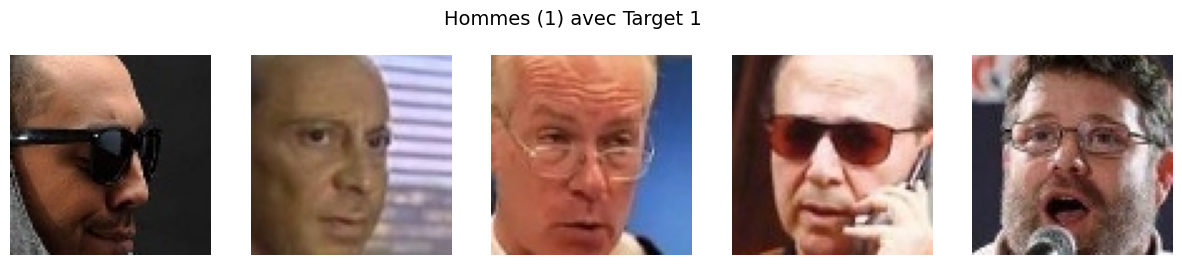

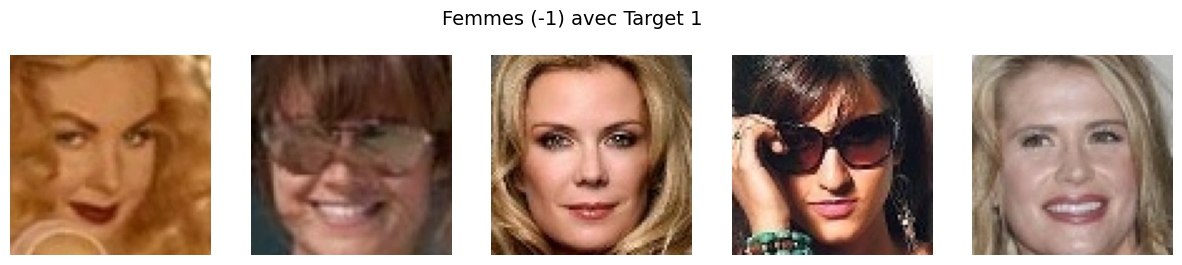

In [12]:
print("\n--- Visualisation des échantillons ---")
show_examples(df, TRAIN_DIR, target=1, gender=1, title="Hommes (1) avec Target 1")
show_examples(df, TRAIN_DIR, target=1, gender=-1, title="Femmes (-1) avec Target 1")

Génération des cartes de saillance...


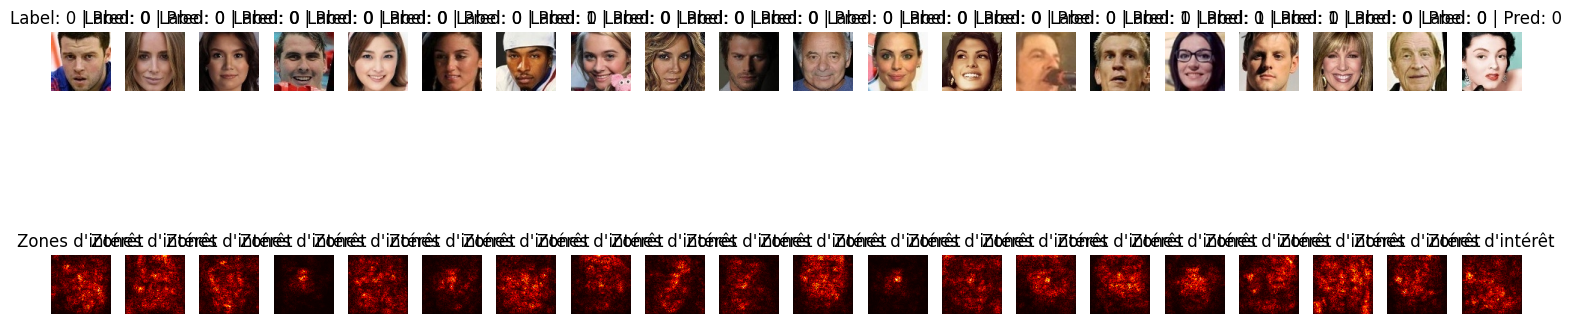

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. Fonction pour générer la Saliency Map
def get_saliency_map(model, image_tensor, label_target):
    """
    Calcule les gradients de l'image par rapport au label prédit.
    """
    # On active le calcul du gradient sur l'image d'entrée (normalement désactivé)
    image_tensor.requires_grad_()

    # Forward pass
    output = model(image_tensor)

    # On veut expliquer la classe prédite (ou la classe cible 1)
    # Ici, on maximise le score de la sortie brute
    output.backward()

    # On récupère les gradients (l'importance des pixels)
    saliency = image_tensor.grad.data.abs()

    # On prend le max sur les 3 canaux de couleur (R, G, B) pour avoir une map 2D
    saliency, _ = torch.max(saliency, dim=1)

    return saliency

# 2. Visualisation sur quelques images
def show_saliency_maps(model, loader, device, n_samples=5):
    model.eval()

    # On récupère un batch
    images, targets, genders = next(iter(loader))
    images = images.to(device)

    fig, ax = plt.subplots(2, n_samples, figsize=(15, 6))

    count = 0
    for i in range(len(images)):
        if count >= n_samples: break

        img_tensor = images[i].unsqueeze(0) # Ajoute dimension batch [1, 3, 80, 80]

        # On ne traite que les images prédites comme "1" (pour voir ce qui déclenche le 1)
        logit = model(img_tensor)
        pred = 1 if torch.sigmoid(logit).item() > 0.5 else 0

        # Affiche l'image originale (Dénormalisation pour l'affichage)
        img_display = images[i].cpu().numpy().transpose(1, 2, 0)
        img_display = img_display * 0.5 + 0.5 # De-normalize

        # Calcul Saliency
        # Note : on doit "reset" le gradient du modèle pour éviter les erreurs
        model.zero_grad()
        saliency = get_saliency_map(model, img_tensor, pred)

        # Affichage Image
        ax[0, count].imshow(np.clip(img_display, 0, 1))
        ax[0, count].set_title(f"Label: {int(targets[i].item())} | Pred: {pred}")
        ax[0, count].axis('off')

        # Affichage Heatmap
        saliency_map = saliency.cpu().numpy()[0]
        ax[1, count].imshow(saliency_map, cmap='hot')
        ax[1, count].set_title("Zones d'intérêt")
        ax[1, count].axis('off')

        count += 1

    plt.tight_layout()
    plt.show()

# --- Exécution ---
# Assurez-vous que 'model' et 'val_loader' sont chargés (Step 3)
print("Génération des cartes de saillance...")
show_saliency_maps(model, val_loader, DEVICE, n_samples=20)

Comparaison des zones d'intérêt (Target 1 vs Target -1)...


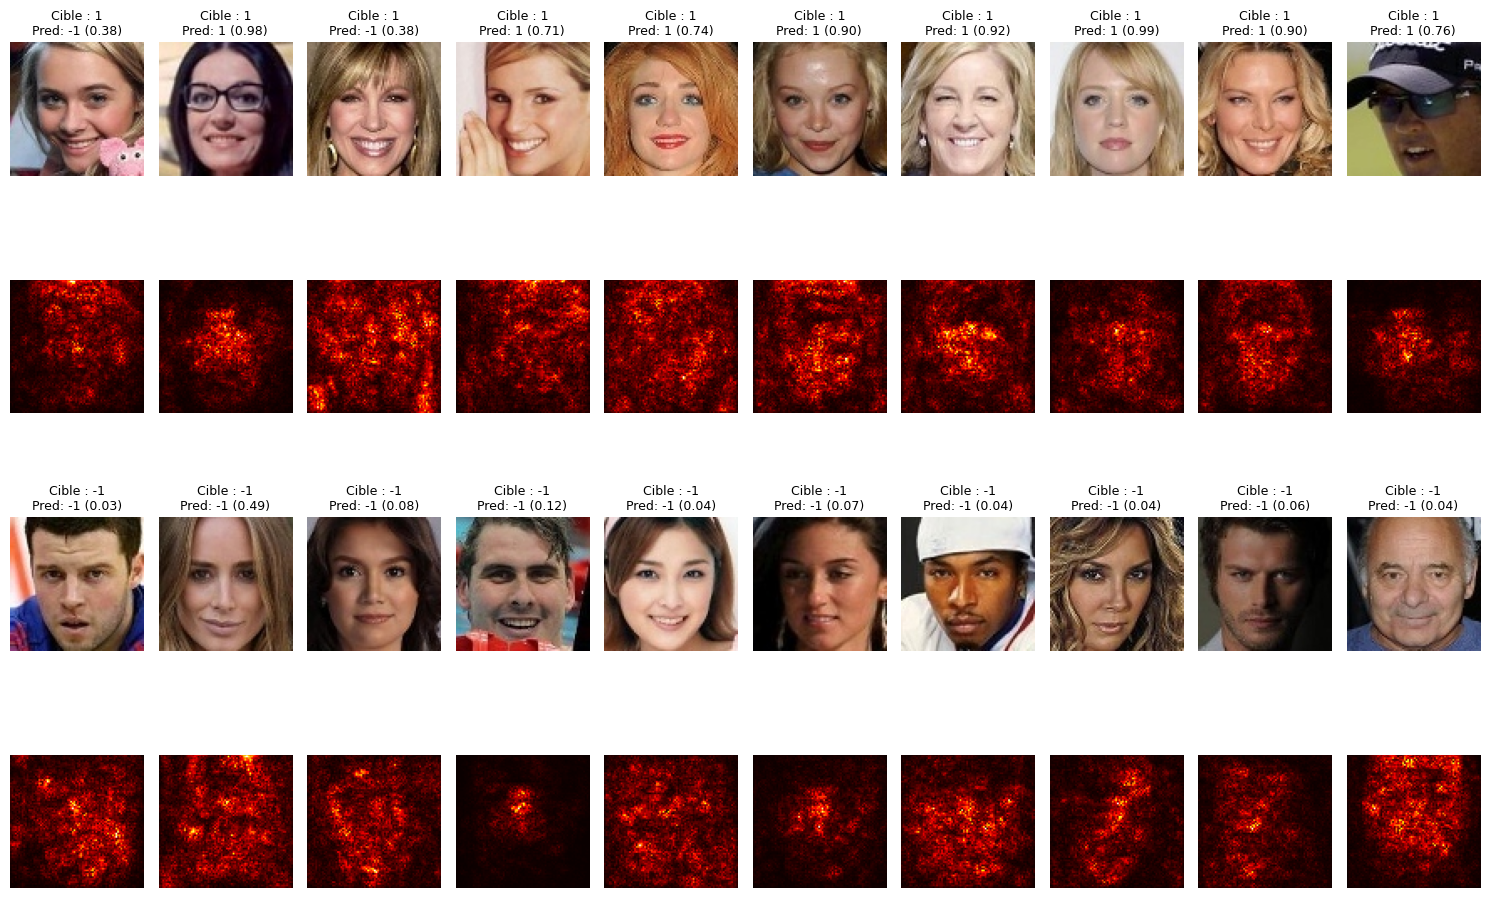

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Fonction de calcul du gradient (Saliency)
def get_saliency_map(model, image_tensor, predicted_class):
    image_tensor.requires_grad_()
    output = model(image_tensor)

    # On veut savoir quels pixels poussent vers la décision prise
    # Si le modèle prédit 1, on backprop pour maximiser le neuron 1
    # (Ici output est un logit unique, donc on backprop directement)
    output.backward()

    saliency = image_tensor.grad.data.abs()
    saliency, _ = torch.max(saliency, dim=1) # Aplatir les canaux RGB
    return saliency

def visualize_comparison(model, loader, device):
    model.eval()

    # Listes pour stocker nos échantillons
    samples_pos = [] # Pour Target 1
    samples_neg = [] # Pour Target -1 (Note: c'est 0 dans le dataset PyTorch)

    # On parcourt le loader jusqu'à avoir 5 de chaque
    for images, targets, _ in loader:
        if len(samples_pos) >= 10 and len(samples_neg) >= 10:
            break

        for i in range(len(images)):
            target_val = int(targets[i].item())

            if target_val == 1 and len(samples_pos) < 10:
                samples_pos.append(images[i])
            elif target_val == 0 and len(samples_neg) < 10:
                samples_neg.append(images[i])

    # Fonction d'affichage d'une ligne
    def plot_row(samples, title_prefix, row_idx_start):
        for i, img_tensor in enumerate(samples):
            img_input = img_tensor.unsqueeze(0).to(device)

            # Prédiction
            logit = model(img_input)
            prob = torch.sigmoid(logit).item()
            pred_label = 1 if prob > 0.5 else -1 # Affichage en label original (-1/1)

            # Saliency
            model.zero_grad()
            saliency = get_saliency_map(model, img_input, pred_label)

            # Préparation affichage
            img_display = img_tensor.cpu().numpy().transpose(1, 2, 0)
            img_display = img_display * 0.5 + 0.5 # Dénormalisation
            saliency_map = saliency.cpu().numpy()[0]

            # Plot Image Originale
            ax[row_idx_start, i].imshow(np.clip(img_display, 0, 1))
            ax[row_idx_start, i].set_title(f"{title_prefix}\nPred: {pred_label} ({prob:.2f})", fontsize=9)
            ax[row_idx_start, i].axis('off')

            # Plot Heatmap
            ax[row_idx_start + 1, i].imshow(saliency_map, cmap='hot')
            ax[row_idx_start + 1, i].axis('off')

    # Création de la figure (4 lignes : Images Pos, Heatmap Pos, Images Neg, Heatmap Neg)
    fig, ax = plt.subplots(4, 10, figsize=(15, 10))

    # Lignes 1 et 2 : Target 1
    plot_row(samples_pos, "Cible : 1", 0)
    ax[0, 0].set_ylabel("Original (1)", size='large')
    ax[1, 0].set_ylabel("Saliency (1)", size='large')

    # Lignes 3 et 4 : Target -1
    plot_row(samples_neg, "Cible : -1", 2)
    ax[2, 0].set_ylabel("Original (-1)", size='large')
    ax[3, 0].set_ylabel("Saliency (-1)", size='large')

    plt.tight_layout()
    plt.show()

# --- Lancement ---
# Assurez-vous que 'model' et 'val_loader' sont définis (Step 3)
print("Comparaison des zones d'intérêt (Target 1 vs Target -1)...")
visualize_comparison(model, val_loader, DEVICE)